In [1]:
#!pip install --upgrade ipywidgets
#!pip install --upgrade tqdm

In [1]:
import torch
import numpy as np

# version and gpu
print(torch.__version__)
print(torch.cuda.is_available())

# add gpu support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

2.2.1+cu121
True
cuda


In [10]:
# load data 
# Load data
data_paths = [
    "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy",
    "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy",
    "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy",
    "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"
]

manta, xiris, y, feats = [np.load(path) for path in data_paths]
print("manta shape:", manta.shape)
print("xiris shape:", xiris.shape)
print("y shape:", y.shape)
print("feats shape:", feats.shape)

manta shape: (9587, 320, 320)
xiris shape: (9587, 320, 320)
y shape: (9587, 2)
feats shape: (9587, 8)


In [11]:
# expand dimensions
manta = np.expand_dims(manta, axis=1)
xiris = np.expand_dims(xiris, axis=1)

print("manta shape:", manta.shape)

# create X that concatnates manta and xiris where manta is the first channel and xiris is the second an manta again in 3rd channel
X = np.concatenate((manta, xiris), axis=1)
print("X shape:", X.shape) # (n_samples, n_channels, height, width)

manta shape: (9587, 1, 320, 320)
X shape: (9587, 2, 320, 320)


In [12]:
# lenght and height -> y
# Get max of each column and normalize
lh = feats[:, 1:3]

# remove outliers based on the mean and std
mean = np.mean(lh, axis=0)
std = np.std(lh, axis=0)
print("mean:", mean)
print("std:", std)

# remove outliers with 3 std
idx = (np.abs(lh - mean) < 3 * std).all(axis=1)

# remove outliers
X = X[idx]
y = y[idx]
lh = lh[idx]



mean: [134.77907583  65.63460937]
std: [53.70412753 17.47088963]


In [14]:
# print shapes
print("X shape:", X.shape)
print("y shape:", y.shape)
print("lh shape:", lh.shape)

X shape: (9419, 2, 320, 320)
y shape: (9419, 2)
lh shape: (9419, 2)


In [15]:
# reshape X to (n_samples*2, n_channels=1, height, width)
X = X.reshape(-1, 1, 320, 320)
print("X shape:", X.shape)


X shape: (18838, 1, 320, 320)


In [16]:

max_lh = np.max(lh, axis=0)
lh = lh / max_lh

# calculate the max of lh
max_y = np.max(y, axis=0)
print("max_y:", max_y)
# normalize y
y = y / max_y

print("lh shape:", lh.shape)
print("lh max:", max_lh)
print("params shape:", y.shape)

# concatenate y to y
y = np.concatenate((y, y), axis=0)
lh = np.concatenate((lh, lh), axis=0)
print("y shape:", y.shape)

#concatenate y and lh to y
y = np.concatenate((y, lh), axis=1)
print("y shape:", y.shape)

max_y: [2750   15]
lh shape: (9419, 2)
lh max: [225.  91.]
params shape: (9419, 2)
y shape: (18838, 2)
y shape: (18838, 4)


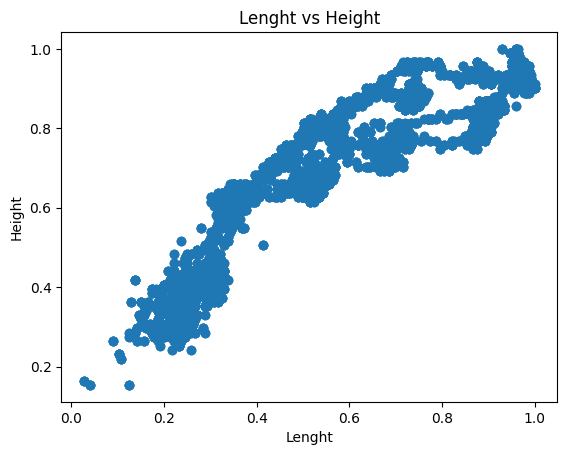

In [17]:
# Plot Lenght and Height
import matplotlib.pyplot as plt
plt.scatter(lh[:, 0], lh[:, 1])
plt.xlabel("Lenght")
plt.ylabel("Height")
plt.title("Lenght vs Height")
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

del X, y, manta, xiris, feats, lh

In [22]:
BATCH_SIZE = 32
# create a dataloader and transfor the data (resize to target size of 224x224)
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# img = transform.resize(image, (new_h, new_w))

img_size = (320, 320)

# apply data augmentation
transform_train = transforms.Compose([
    transforms.Resize(img_size),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(20),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
transform_test = transforms.Compose([
    transforms.Resize(img_size),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# create dataset
class CustomDataset(TensorDataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
        # convert to tensor
        self.X = torch.tensor(self.X, dtype=torch.float32).to(device)
        self.y = torch.tensor(self.y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]

        if self.transform:
            sample = self.transform(sample)
        # make sure the sample is between 0 and 1
        sample = torch.clamp(sample, 0, 1)

        return sample, label
    
# create dataloaders
train_dataset = CustomDataset(X_train, y_train, transform_train)
val_dataset = CustomDataset(X_val, y_val, transform_test)
test_dataset = CustomDataset(X_test, y_test, transform_test)


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#del X_train, X_val, X_test, y_train, y_val, y_test

Image shape: torch.Size([1, 320, 320])
Max val: 0.7914348244667053
Min: 0.18747825920581818
tensor([[0.1987, 0.2021, 0.2007,  ..., 0.1962, 0.2039, 0.2002],
        [0.2091, 0.2008, 0.2057,  ..., 0.2050, 0.2093, 0.1998],
        [0.2037, 0.1966, 0.1919,  ..., 0.1943, 0.2092, 0.2036],
        ...,
        [0.2345, 0.2373, 0.2356,  ..., 0.2259, 0.2242, 0.2194],
        [0.2309, 0.2348, 0.2274,  ..., 0.2153, 0.2216, 0.2157],
        [0.2319, 0.2309, 0.2314,  ..., 0.2193, 0.2160, 0.2243]])


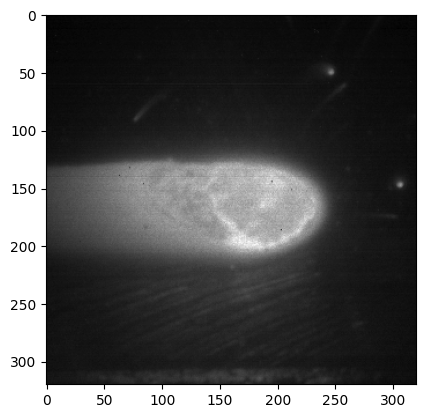

In [23]:
import matplotlib.pyplot as plt

# Function to visualize images from DataLoader
def visualize_single_image(dataloader):
    # Get a batch of data
    batch = next(iter(dataloader))
    images, labels = batch 
    
    # Get the first image
    img = images[0]
    
    # get to cpu
    img = img.cpu()
    # print shape
    print("Image shape:", img.shape)
    
    # Print max and min values for each channel in the current image
    print("Max val:", torch.max(img).item())
    print("Min:",  torch.min(img).item())

    # Convert to numpy array
    #img = img.numpy()
    print(img[0])
    
    # Plot the image
    plot = plt.imshow(img[0], cmap='gray')
    

# Visualize one image from training DataLoader
visualize_single_image(train_dataloader)


In [26]:
from transformers import ViTConfig, ViTModel

# Load the configuration of the pre-trained ViT model
configuration = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")

# change the number of channels to 1
configuration.num_channels = 1

configuration.image_size = 320

print(configuration)

# Load the pre-trained ViT model
model = ViTModel(configuration)

test_model = False

if test_model:
    # model to device
    model.to(device)

    # test the model in a batch
    for images, labels in train_dataloader:
        print('images.shape:', images.shape)
        outputs = model(images)
        print(outputs.last_hidden_state.shape)
        break

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 320,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 1,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.38.1"
}



In [27]:
import torch.nn as nn

class CustomViTRegression(nn.Module):
    def __init__(self, vit_model):
        super(CustomViTRegression, self).__init__()
        self.vit_model = vit_model
        self.embedding_layer = nn.Linear(768, 128)  # Adding the embedding layer
        #self.merge_embeddings = nn.Linear(256, 256)  # Adding the embedding layer
        self.regressor = nn.Linear(256, 2)  # Adding the regression layer

    def forward(self, x):
        # Forward pass through ViT model
        x = self.vit_model(x)

        # Get the representation after ViT
        # Assuming the representation is the output of the last ViT layer
        representation = x.last_hidden_state[:, 0]

        # Apply the embedding layer
        embeddings_P = self.embedding_layer(representation)
        embeddings_V = self.embedding_layer(representation)
        
        # merge the embeddings P and V        
        merge_embeddings = torch.cat((embeddings_P, embeddings_V), dim=1)
        
        # Apply the regression layer
        regression_output = self.regressor(merge_embeddings)
             
        return embeddings_P, embeddings_V, regression_output

# Initialize the custom model
custom_model = CustomViTRegression(model)

# Print the custom model
print(custom_model)

# add model to device
custom_model.to(device)

# test the model in a batch
for images, labels in train_dataloader:
    print('images.shape:', images.shape)
    
    images = images.to(device)
    
    embeddings_P, embeddings_V, regression_output = custom_model(images)
    print(embeddings_P.shape)
    print(embeddings_V.shape)
    print(regression_output.shape)
    break


CustomViTRegression(
  (vit_model): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [28]:
#! pip install pytorch-metric-learning --pre
from pytorch_metric_learning import losses
import torch.nn.functional as F

class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, feature_vectors, labels):
        # Normalize feature vectors
        feature_vectors_normalized = F.normalize(feature_vectors, p=2, dim=1)
        # Compute logits
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
            ),
            self.temperature,
        )
        return losses.NTXentLoss(temperature=0.05)(logits, torch.squeeze(labels))

In [29]:
from tqdm import tqdm 

# Assuming 'custom_model' is already defined and needs to be moved to the appropriate device
custom_model.to(device)

# Define the supervised contrastive loss
criterion = SupervisedContrastiveLoss(temperature=0.1)
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.000_01)

regression_criterion = nn.MSELoss()

# Train the model
n_epochs = 50
train_losses = []
val_losses = []
len_train_loader = len(train_dataloader)
len_val_loader = len(val_dataloader)

for epoch in range(n_epochs):
    # Train
    custom_model.train()
    train_loss = 0.0
    # Wrap the training data loader with tqdm
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')):
        images, labels = batch      
        optimizer.zero_grad()
        outputs = custom_model(images)
        loss_P = criterion(outputs[0], labels[:, 0])
        loss_V = criterion(outputs[1], labels[:, 1])
        
        loss_regresion = regression_criterion(outputs[2], labels[:, 2:])
        
        loss = (loss_P + loss_V) / 2 + loss_regresion
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len_train_loader
    train_losses.append(train_loss)
    
    # Evaluation
    custom_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        # Wrap the testing data loader with tqdm
        for batch in tqdm(val_dataloader, desc='Validation'):
            images, labels = batch
            images = images.to(device)  # Move data to GPU
            labels = labels.to(device)  # Move data to GPU
            outputs = custom_model(images)
            loss_P = criterion(outputs[0], labels[:,0])
            loss_V = criterion(outputs[1], labels[:,1])
            
            loss_regresion = regression_criterion(outputs[2], labels[:, 2:])
            
            
            loss = (loss_P + loss_V) / 2 + loss_regresion
            val_loss += loss.item()
    val_loss /= len_val_loader
    val_losses.append(val_loss)
    
    # Print training and validation information
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Optionally save the trained model
#torch.save(custom_model.state_dict(), 'trained_model.pth')


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.49it/s]


Epoch 1/50, Training Loss: 3.0366, Validation Loss: 3.0312


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 2/50, Training Loss: 3.0290, Validation Loss: 3.0228


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.52it/s]


Epoch 3/50, Training Loss: 3.0259, Validation Loss: 3.0290


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.48it/s]


Epoch 4/50, Training Loss: 3.0137, Validation Loss: 3.0211


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 5/50, Training Loss: 2.9921, Validation Loss: 2.9526


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 6/50, Training Loss: 2.9659, Validation Loss: 2.9437


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.50it/s]


Epoch 7/50, Training Loss: 2.9381, Validation Loss: 2.9217


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.49it/s]


Epoch 8/50, Training Loss: 2.9055, Validation Loss: 2.8518


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.49it/s]


Epoch 9/50, Training Loss: 2.8670, Validation Loss: 2.8389


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 10/50, Training Loss: 2.8538, Validation Loss: 2.8026


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.49it/s]


Epoch 11/50, Training Loss: 2.8393, Validation Loss: 2.8002


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 12/50, Training Loss: 2.8152, Validation Loss: 2.8522


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 13/50, Training Loss: 2.8056, Validation Loss: 2.7896


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.49it/s]


Epoch 14/50, Training Loss: 2.7982, Validation Loss: 2.7812


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 15/50, Training Loss: 2.7978, Validation Loss: 2.7811


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 16/50, Training Loss: 2.7827, Validation Loss: 2.6778


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 17/50, Training Loss: 2.6476, Validation Loss: 2.5376


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.48it/s]


Epoch 18/50, Training Loss: 2.5296, Validation Loss: 2.4838


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 19/50, Training Loss: 2.4834, Validation Loss: 2.4444


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 20/50, Training Loss: 2.4452, Validation Loss: 2.4970


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 21/50, Training Loss: 2.4271, Validation Loss: 2.4287


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 22/50, Training Loss: 2.4130, Validation Loss: 2.5316


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.50it/s]


Epoch 23/50, Training Loss: 2.4087, Validation Loss: 2.3915


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.51it/s]


Epoch 24/50, Training Loss: 2.3971, Validation Loss: 2.3701


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.47it/s]


Epoch 25/50, Training Loss: 2.3636, Validation Loss: 2.3632


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.48it/s]


Epoch 26/50, Training Loss: 2.3934, Validation Loss: 2.3571


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.47it/s]


Epoch 27/50, Training Loss: 2.3789, Validation Loss: 2.3473


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.45it/s]


Epoch 28/50, Training Loss: 2.3482, Validation Loss: 2.3714


Validation: 100%|██████████| 95/95 [00:18<00:00,  5.25it/s]


Epoch 29/50, Training Loss: 2.3797, Validation Loss: 2.3371


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.47it/s]


Epoch 30/50, Training Loss: 2.3325, Validation Loss: 2.2614


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.43it/s]


Epoch 31/50, Training Loss: 2.2775, Validation Loss: 2.2664


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.46it/s]


Epoch 32/50, Training Loss: 2.2994, Validation Loss: 2.3819


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.46it/s]


Epoch 33/50, Training Loss: 2.2455, Validation Loss: 2.2538


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.46it/s]


Epoch 34/50, Training Loss: 2.2670, Validation Loss: 2.2127


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.45it/s]


Epoch 35/50, Training Loss: 2.2132, Validation Loss: 2.2188


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.44it/s]


Epoch 36/50, Training Loss: 2.2061, Validation Loss: 2.1549


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.47it/s]


Epoch 37/50, Training Loss: 2.1832, Validation Loss: 2.3109


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.48it/s]


Epoch 38/50, Training Loss: 2.1784, Validation Loss: 2.1821


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.46it/s]


Epoch 39/50, Training Loss: 2.1751, Validation Loss: 2.1363


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.46it/s]


Epoch 40/50, Training Loss: 2.1606, Validation Loss: 2.1777


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.43it/s]


Epoch 41/50, Training Loss: 2.2089, Validation Loss: 2.2074


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.41it/s]


Epoch 42/50, Training Loss: 2.1524, Validation Loss: 2.1130


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.44it/s]


Epoch 43/50, Training Loss: 2.1485, Validation Loss: 2.1644


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.38it/s]


Epoch 44/50, Training Loss: 2.1441, Validation Loss: 2.1437


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.45it/s]


Epoch 45/50, Training Loss: 2.1188, Validation Loss: 2.2302


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.47it/s]


Epoch 46/50, Training Loss: 2.1090, Validation Loss: 2.1345


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.44it/s]


Epoch 47/50, Training Loss: 2.1070, Validation Loss: 2.1163


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.46it/s]


Epoch 48/50, Training Loss: 2.1026, Validation Loss: 2.2930


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.48it/s]


Epoch 49/50, Training Loss: 2.1172, Validation Loss: 2.0935


Validation: 100%|██████████| 95/95 [00:17<00:00,  5.30it/s]

Epoch 50/50, Training Loss: 2.0888, Validation Loss: 2.0819


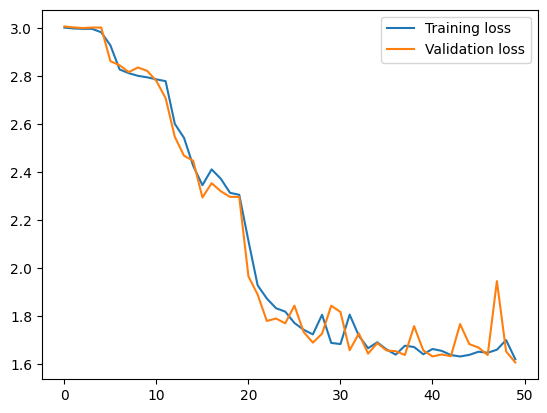

In [14]:
# plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()


Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Validation: 100%|██████████| 120/120 [00:09<00:00, 12.17it/s]


Mean Squared Error: 0.0013


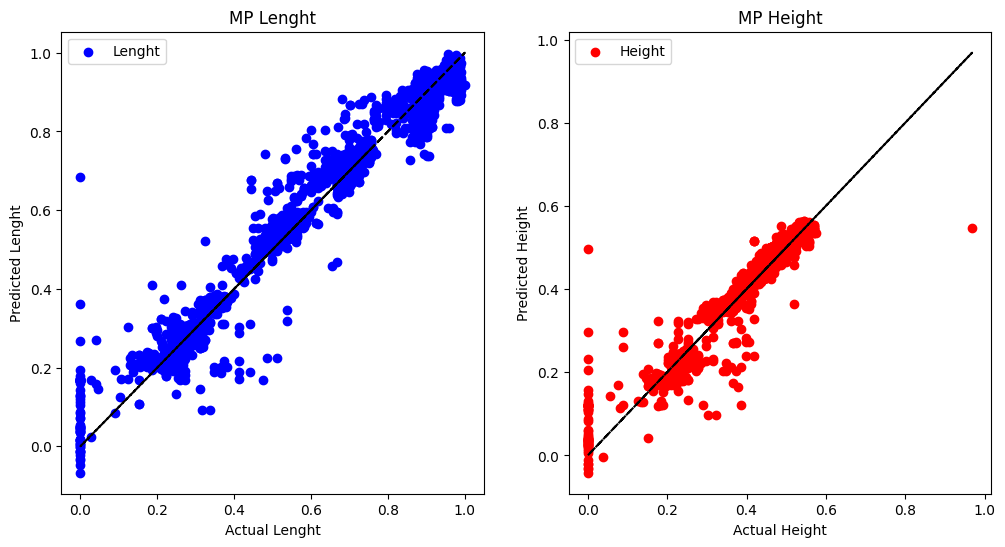

In [18]:
# Set the model to evaluation mode
custom_model.eval()

# Create empty lists to store the predicted and actual labels
predicted_labels = []
actual_labels = []

# No need to track gradients during validation
with torch.no_grad():
    # Iterate over the test DataLoader
    for batch in tqdm(test_dataloader, desc='Validation'):
        images, labels = batch # Move data to GPU
        outputs = custom_model(images)
        predicted_labels.append(outputs[2].cpu())  # Move predictions to CPU
        actual_labels.append(labels[:, 2:4].cpu())  # Move actual labels to CPU

# Concatenate the lists to obtain the predicted and actual labels
predicted_labels = torch.cat(predicted_labels)
actual_labels = torch.cat(actual_labels)

# Calculate the mean squared error
mse = nn.MSELoss()
loss = mse(predicted_labels, actual_labels)
print(f"Mean Squared Error: {loss.item():.4f}")

# Plot the predicted and actual labels
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(actual_labels[:, 0], predicted_labels[:, 0], label='Lenght', color='blue')
plt.plot(actual_labels[:, 0], actual_labels[:, 0], color='black', linestyle='--')  # Identity line
plt.xlabel('Actual Lenght')
plt.ylabel('Predicted Lenght')
plt.title('MP Lenght')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(actual_labels[:, 1], predicted_labels[:, 1], label='Height', color='red')
plt.plot(actual_labels[:, 1], actual_labels[:, 1], color='black', linestyle='--')  # Identity line
plt.xlabel('Actual Height')
plt.ylabel('Predicted Height')
plt.title('MP Height')
plt.legend()

#plt.tight_layout()
plt.show()


In [ ]:
# print layer names 
for name, param in custom_model.named_parameters():
    print(name, param.shape)

vit_model.embeddings.cls_token torch.Size([1, 1, 768])
vit_model.embeddings.position_embeddings torch.Size([1, 197, 768])
vit_model.embeddings.patch_embeddings.projection.weight torch.Size([768, 1, 16, 16])
vit_model.embeddings.patch_embeddings.projection.bias torch.Size([768])
vit_model.encoder.layer.0.attention.attention.query.weight torch.Size([768, 768])
vit_model.encoder.layer.0.attention.attention.query.bias torch.Size([768])
vit_model.encoder.layer.0.attention.attention.key.weight torch.Size([768, 768])
vit_model.encoder.layer.0.attention.attention.key.bias torch.Size([768])
vit_model.encoder.layer.0.attention.attention.value.weight torch.Size([768, 768])
vit_model.encoder.layer.0.attention.attention.value.bias torch.Size([768])
vit_model.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
vit_model.encoder.layer.0.attention.output.dense.bias torch.Size([768])
vit_model.encoder.layer.0.intermediate.dense.weight torch.Size([3072, 768])
vit_model.encoder.layer.0.i

In [ ]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register the forward hook to the embedding layer
layer_name = 'embedding_layer'
custom_model.embedding_layer.register_forward_hook(get_activation(layer_name))

# Set the model to evaluation mode
model.eval()

# Assuming you have test_dataloader defined
batch = next(iter(test_dataloader))
images, labels = batch

# Forward pass
output = custom_model(images)

# Print the shape of the activation features
print(activation[layer_name].shape)


torch.Size([32, 512])


In [ ]:
# Lists to store embeddings and labels for all batches
all_embeddings = []
all_labels = []

# Set the model to evaluation mode
custom_model.eval()

# Iterate through all batches in the test_dataloader
with torch.no_grad():
    for batch in test_dataloader:
        images, labels = batch
        # Forward pass through the custom model
        embeddings = custom_model(images)
        # Store the embeddings for the current batch
        all_embeddings.append(embeddings.cpu().numpy())
        # Store the labels for the current batch
        all_labels.append(labels.cpu().numpy())

# Concatenate embeddings and labels from all batches
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Print the shapes of the concatenated embeddings and labels
print("Embeddings shape:", all_embeddings.shape)
print("Labels shape:", all_labels.shape)


Embeddings shape: (1918, 2)
Labels shape: (1918, 2)


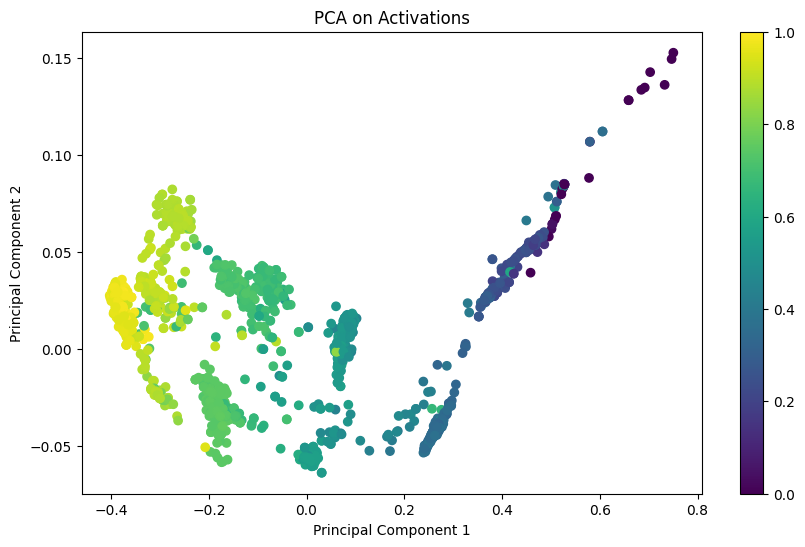

In [ ]:
# Perform PCA
from sklearn.decomposition import PCA

# Create PCA instance
pca = PCA(n_components=2)

# Fit PCA to your activations data
pca_result = pca.fit_transform(all_embeddings)

# plot PCA
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=all_labels[:, 0], cmap='viridis')
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Activations')
plt.show()


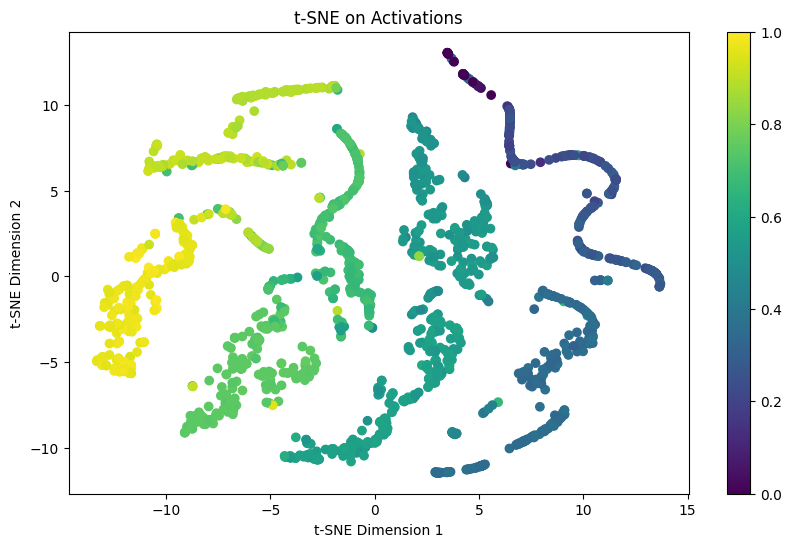

In [ ]:
# Perform t-SNE
from sklearn.manifold import TSNE

# Create t-SNE instance
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)

# Fit t-SNE to your activations data
tsne_result = tsne.fit_transform(all_embeddings)

# plot t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=all_labels[:, 0], cmap='viridis')
plt.colorbar()
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE on Activations')
plt.show()
